# How to Calibrate TopoFlow with Gauge Data

#### Table of Contents

1.  <a href="#intro_G">Introduction</a> <br>
2.  <a href="#install_G">How to Install the TopoFlow Python Package</a> <br>
3.  <a href="#baro_G">Baro River Basin, Gambella, Ethiopia</a> <br>
4.  <a href="#guess_G">Calibration vs. Best-Guess Parameters</a> <br>
5.  <a href="#cost_fcn_G">Defining the Cost Function</a> <br>
6.  <a href="#gauge_data_G">River Discharge Data for Treynor Creek, Iowa</a> <br>
7.  <a href="#calibrate_G">TopoFlow Calibration for Treynor Creek </a> <br>
8.  <a href="#conclusions_G">Conclusions </a> <br> 
9.  <a href="#notebooks_G">Other Jupyter Notebooks for TopoFlow 3.6 </a> <br>
10. <a href="#refs_G">Key References for TopoFlow</a> <br>
11. <a href="#setup_G">Appendix 1: Installing TopoFlow in a conda Environment</a>

<!-- Hyperlink IDs must be unique to work in Jupyter Lab when
there are multiple notebooks open. Hence the trailing letter. -->

## Introduction  <a id="intro_G"></a>

This notebook shows a simple model calibration exercise for the TopoFlow 3.6 hydrologic model that uses river discharge measurements from a gauging station.  Model calibration is computationally expensive and is best performed on supercomputers with specialized toolkits such as [<b>DAKOTA</b>](https://dakota.sandia.gov/) from DOE's Sandia Labs.  It basically involves performing a very large number of model runs with different combinations of the adjustable parameters to find the set of parameters that results in the closest match between observations of some variable and model predictions for the same variable.  The goal of this notebook is to show how calibration works using a grealy <b>simplified example</b> where only one model parameter is considered to be adjustable.  A future notebook will illustrate a more complex and realistic example of model calibration for TopoFlow.


## How to Install the TopoFlow Python Package  <a id="install_G"></a>

Before you can run the code in this notebook, you will need to install the TopoFlow 3.6 Python package.

Detailed instructions and background information for how to install TopoFlow in a conda environment are given in
<a href="#setup"><b>Appendix 1:  Installing TopoFlow in a conda Environment</b></a>.

## Baro River Basin, Gambela, Ethiopia  <a id="baro_G"></a>

The 
[<b>Baro River</b>](https://en.wikipedia.org/wiki/Baro_River)
is a large tributary of the
[<b>Sobat River</b>](https://en.wikipedia.org/wiki/Sobat_River)
that flows westward from the
[<b>Ethiopian Highlands</b>](https://en.wikipedia.org/wiki/Ethiopian_Highlands)
and lies partly within both the
[<b>Oromia</b>](https://en.wikipedia.org/wiki/Oromia_Region)
and
[<b>Gambela</b>](https://en.wikipedia.org/wiki/Gambela_Region)
regions.  It is about 150 meters wide as it passes through the
[<b>town of Gambela</b>](https://en.wikipedia.org/wiki/Gambela,_Ethiopia),
and drains a contributing area of over 41,000 square kilometers.

<table> <tr>
  <td> 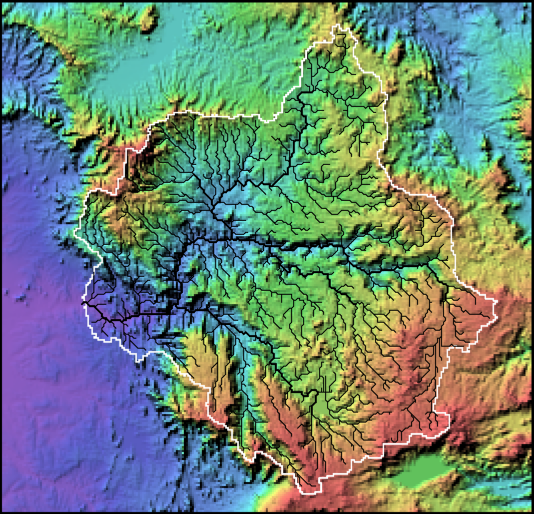
</tr> </table>

<b>Figure.</b> A color, shaded-relief image of the Baro River basin, in Ethiopia, where red is high elevation and blue is lower elevation.  Black lines show the river network and the white polygon is the watershed boundary.

## Calibration vs. Best-Guess Parameters  <a id="guess_G"></a>

Model <b>calibration</b> is one commonly-used method for
[<b>parameter estimation</b>](https://en.wikipedia.org/wiki/Estimation_theory)
(PE).  This method requires the use of a
[<b>cost function</b>](https://en.wikipedia.org/wiki/Loss_function)
that compares the <b>observed</b> or measured values of some variable to the values that are <b>predicted</b> by a model for that same variable.  It is important to understand that this method of parameter estimation <b>requires</b> observational data;  it cannot be used when observational data is unavailable.  For most of the river basins in the world, and especially on the African continent, observational data is only available for a relatively small number of river basins;  typically just the largest basins.

For hydrologic models, it is common to use a time series of
[<b>river discharge</b>](https://en.wikipedia.org/wiki/Discharge_(hydrology))
(which has units of volume per time), as the variable that is both observed and predicted, at some river basin outlet where there is a gauging station.  The modeler decides which model parameters will be held fixed and which will be allowed to be set by this method, and the model is then run many, many times, each time using a different set of possible parameter values (over allowed ranges) and each time computing the value of the cost function.  This is an
[<b>optimization problem</b>](https://en.wikipedia.org/wiki/Optimization_problem),
where one seeks the global minimum of the cost function over the model's
[<b>parameter space</b>](https://en.wikipedia.org/wiki/Parameter_space).
The cost function is often simply an
[<b>L2 norm</b>](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm)
(i.e. least squares difference) that measures how close the model predictions are to the observations.  When finished, the model's adjustable parameters are set to those of the model run that minimized the cost function.  Unfortunately, it can happen that many different sets of parameters will minimize the cost function equally well, and this problem is called
[<b>equifinality</b>](https://en.wikipedia.org/wiki/Equifinality).

Since model calibration utilizes observational data, measurement errors of any kind can be a problem.  Also, a model must be recalibrated when it is applied to a different location (e.g. another river basin).  And due to the likely
[<b>nonstationarity</b>](https://en.wikipedia.org/wiki/Stationary_process)
of weather variables, it may also need to be recalibrated when it is applied to different time period or to any circumstances that were not reflected in the observational data (such as a large flood event).

In the common case where observational data is not available, a domain expert will gather as much information about the region (and scenario) of interest as possible, from any available source (e.g. papers, books, websites, global databases, personal communication, etc.), and combine this with his or her understanding of the underlying physics (expert knowledge) and a few assumptions to make <b>best guesses</b> for the values of adjustable parameters.  Neither calibration nor this method is foolproof, so model predictions always have uncertainty.  Note that even a perfect model (if that were possible) will give incorrect and even nonsensical results if its parameters are set incorrectly.

A closely related topic is
[<b>model sensitivity analysis</b>](https://en.wikipedia.org/wiki/Sensitivity_analysis).
As with model calibration, a model sensitivity study requires a model to be run many, many times with different parameter settings.  However, the goal in this case is to determine the degree to which the model predictions (i.e. the numerical values of the output variables) are <b>sensitive</b> to changes in any given parameter.  Physically-based models, where each parameter represents some important aspect of the physics, can be sensitive to many of their parameters.  In some cases a model may even become chaotic or exhibit a discontinuous jump in its predicted values even after a parameter is changed by only a very tiny amount.


## Defining the Cost Function  <a id="cost_fcn_G"></a>

Model calibration is an <b>optimization problem</b>, and this type of problem starts with the definition of a <b>cost function</b>, which may also be called an <b>objective function</b> or a 
[<b>loss function</b>](https://en.wikipedia.org/wiki/Loss_function).

The cost function must be a
[<b>metric</b>](https://en.wikipedia.org/wiki/Metric_(mathematics))
that measures model's performance, defined as an abstract "distance" between the observed and model-predicted values of some output variable. There are many different metrics that can be used, such as those based on the one-parameter family of L<sup>p</sup> norms, given by:

$$ \large{
d \left( \boldsymbol{Y}_{obs}, \boldsymbol{Y}_{sim} \right) =
\left( \sum_{k=1}^n \left| y_k^{(obs)} - y_k^{(sim)} \right|^{\,p} \right)^{1/p}
} $$ 
where
$Y_{obs}$ is a vector of observed values with components $y_k^{\, (obs)}$,
$Y_{sim}$ is a vector of simulated values with components $y_k^{\, (sim)}$,
and $p > 0$ is a scalar. The case where $p = 2$, the or the $L^2$ norm, is the basis of the popular
[<b>least squares</b>](https://en.wikipedia.org/wiki/Least_squares) metric.  While this metric gives disproportionate weight to outliers, it ensures that the derivative of the cost function is continuous where the error is zero.

When calibrating a hydrologic model, it is common to use an observed and simulated time series of <b>river discharge</b> values (at the outlet of a river basin) for the vectors $Y_{obs}$ and $Y_{sim}$.  In this case, $k$ may be seen as a time index.  Notice that the cost, $d$, can only be zero if all of the simulated and observed values are the same.

While not indicated explicitly in the notation above, it is understood that the vector of simulated values, $Y_{sim}$, is a function of the values of all of the model's adjustable parameters, sometimes called <b>control parameters</b> or <b>design parameters</b>.

## River Discharge Data for Treynor Creek, in Iowa  <a id="gauge_data_G"></a>

For this simplified calibration exercise, we will use observed river discharge measurements at the mouth of a small watershed near the town of Treynor, Iowa.  We will refer to this watershed as <b>Treynor Creek</b>.  This is a USDA research watershed.  Treynor creek is a tributary of Silver Creek, in Pottawattamie County (southwest Iowa), which is a tributary of the Nishnabotna River.  This is not far from the city of Council Bluffs.

Extreme rainfall events on June 7, 1967 and June 20, 1967 resulted in 100-year flood events in the vicinity of Treynor Creek.

### Treynor Creek References

Kinner, D.A. and R.F. Stallard (2001)
Calculating hillslope contributions to river basin sediment yield using observations in small watersheds and an index-based model,
American Geophysical Union, Fall Meeting 2001, abstract id. NG51A-0445.

Saxton, K.E., R.G. Spomer and L.A. Kramer (1971)
Hydrology and erosion of loessial watersheds,
J. Hydraulic Division, Proc. ASCE, 23, HY11, 1835-1851.

Spomer, R.G., H.G. Heinemann and R.F. Piest (1971)
Consequences of historic rainfall on western Iowa farmland,
Water Resources Research, 7(3), 524-535.

Vendrusculo, L.G. and A.L. Kaleita (2013)
Terrain analysis and data mining techniques applied to location of a classic gully in a watershed, Proceedings of 2013 ASABE Annual International Meeting, Kansas City, MO, July 21-24, 2013.


## TopoFlow Calibration for Treynor Creek  <a id="calibrate_G"></a>

This is just a simple calibration where we only allow one parameter to vary, for purposes of demonstration.  The procedure is to perform many model runs where we vary that parameter over its allowed range (i.e. we sample the parameter space) and for each run we compute a cost function that compares predictions to observations.  Finally, we save the value of the parameter that minimizes the cost function.

Here we use a TopoFlow utility in <b>topoflow/utils</b> called <b>calibrate.py</b>.

For a full-fledged calibration exercise, where more parameters would be allowed to vary, the best approach is to use a sophisticated toolkit such as
[<b>DAKOTA</b>](https://dakota.sandia.gov/), developed over decades by DOE's Sandia National Lab.
DAKOTA can more rapidly perform a large ensemble of model runs by taking advantage of parallel processing on a supercomputer or cluster.


In [1]:
from topoflow.utils import calibrate

#-----------------------------------------------
# Create an instance of the calibrator class
#-----------------------------------------------
# All of the information for Treynor Creek has
# been used for the default configuration.
# Later, calibrate should have a CFG file.
#-----------------------------------------------
cal = calibrate.calibrator()
cal.print_file_info()
cal.get_observed_values( SILENT=False )
cal.get_simulated_values( SILENT=False )

## rates = calibrate.compute_rain_rates_from_accumulations( SILENT=True )
## print(rates)


Importing TopoFlow 3.6 package modules:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
 
In print_file_info():
  cfg_prefix   = June_20_67
  site_prefix  = Treynor
  examples_dir = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/
  basin_dir    = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/Treynor_Iowa_30m/
  topo_dir     = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/Treynor_Iowa_30m/__topo/
  output_dir   = /Users/peckhams/TF_Output/Treynor/
  cfg_dir      = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/Treynor_Iowa_30m/__No_Infil_June_20_67_rain/
  home_dir     = /Users/peckhams
  obs_dir      = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/Treynor_Iowa_30m/__observations/
  sim_dir      = /Users/peckhams/TF_Output/Treynor/

HHMM_TIMES      = True
IRREGULAR_TIMES = True
Min(obs_times)  = 2057.0
Max(obs_times)  = 2549.0
Min(obs_values) = 0.001

Working...
   param = 0.01
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_16.txt


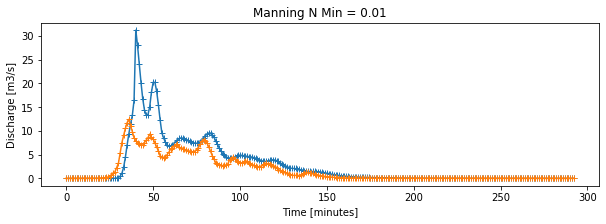

   param = 0.015714286
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_17.txt


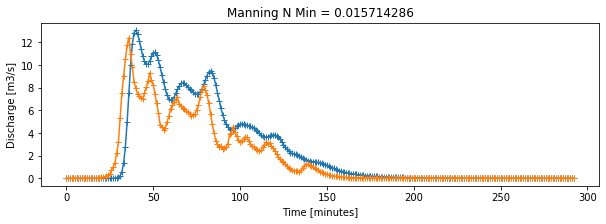

   param = 0.021428574
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_18.txt


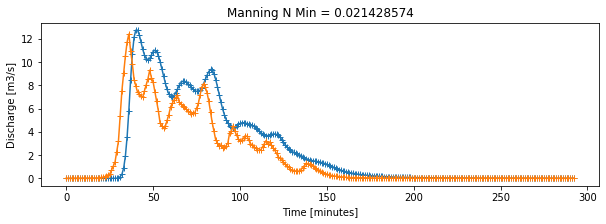

   param = 0.027142858
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_19.txt


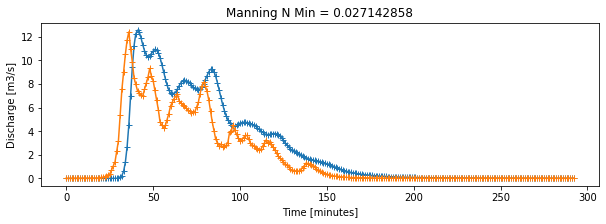

   param = 0.032857146
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_20.txt


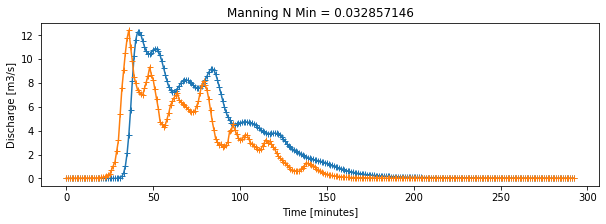

   param = 0.038571432
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_21.txt


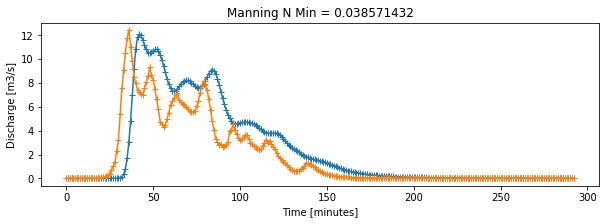

   param = 0.044285715
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_22.txt


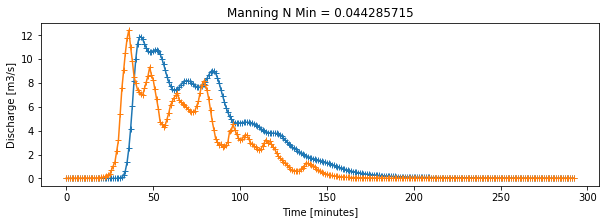

   param = 0.050000004
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_23.txt


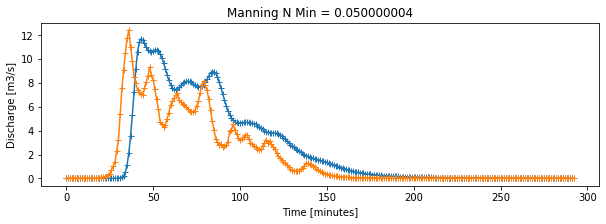

   param = 0.055714294
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_24.txt


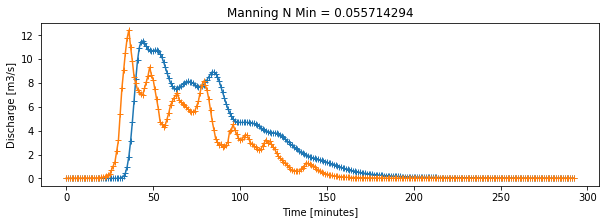

   param = 0.061428577
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_25.txt


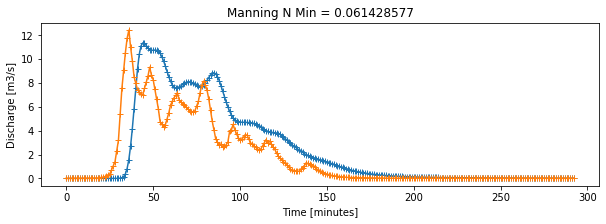

   param = 0.06714286
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_26.txt


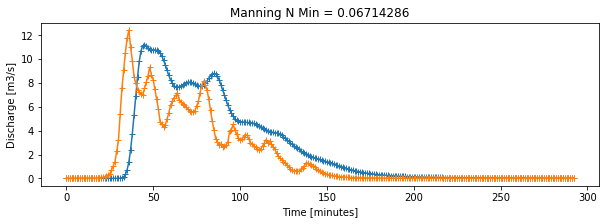

   param = 0.07285714
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_27.txt


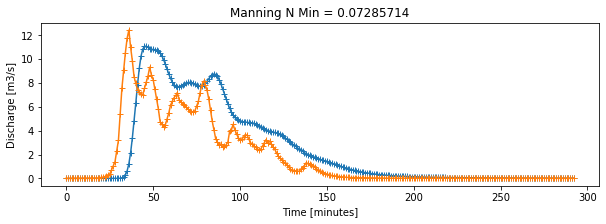

   param = 0.07857143
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_28.txt


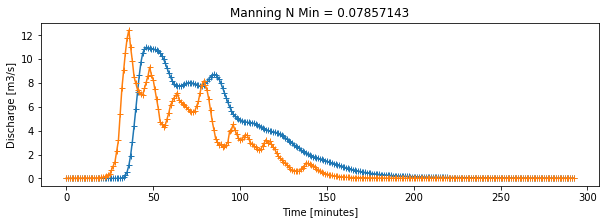

   param = 0.084285714
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_29.txt


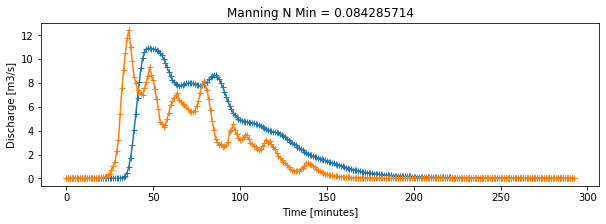

   param = 0.09
target file = /Users/peckhams/TF_Output/Treynor/June_20_67_0D-Q_30.txt


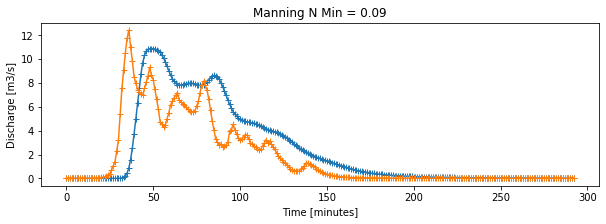

In [2]:
# cal.calibrate( cal_var='channel_width_power', PLOT=True, SILENT=True )
# cal.calibrate( cal_var='channel_width_max', PLOT=True, SILENT=True )
cal.calibrate( cal_var='manning_n_min', PLOT=True, SILENT=True )
# cal.calibrate( cal_var='manning_n_max', PLOT=True, SILENT=True )


In [28]:
print('best param =', cal.best_param)
print('params =', cal.params)
print('costs  =', cal.costs)


best param = 5.5
params = [ 1.         1.6428572  2.2857144  2.9285715  3.5714288  4.214286
  4.857143   5.5        6.1428576  6.785714   7.4285717  8.071428
  8.714286   9.357142  10.       ]
costs  = [45.68111137 41.58054899 39.65353523 38.58215736 37.96858527 37.63220487
 37.46862186 37.41367148 37.42752551 37.48529445 37.57125667 37.67535152
 37.79106368 37.91413007 38.04174433]


In [18]:
n1 = cal.sim_values.size
n2 = cal.obs_values.size
print('n1, n2 =', n1, n2)

smin = cal.sim_values[:n2].min()
smax = cal.sim_values[:n2].max()
omin = cal.obs_values.min()
omax = cal.obs_values.max()
print('smin, smax =', smin, smax)
print('omin, omax =', omin, omax)
print('smax / omax =', smax/omax )

smin, smax = 0.0 15.942776
omin, omax = 0.001488146954216063 12.415397644042969
smax / omax = 1.2841131781202242


In [19]:
ratio = cal.sim_values[:n2] / cal.obs_values
rmin = ratio.min()
rmax = ratio.max()
print('rmin, rmax =', rmin, ', ', rmax)
ravg = (ratio.sum() / n2)
print('ravg =', ravg)
# print( cal.sim_values[:n2] )
# print()
# print( cal.obs_values )

n1, n2 = 300 293
rmin, rmax = 0.0 ,  37.922000899929536
ravg = 5.815278657582462


## Conclusions   <a id="conclusions_G"></a>

The purpose of this notebook was to illustrate the basic concepts of how to calibrate the TopoFlow hydrologic model by varying only one parameter at a time and then showing the observed and predicted hydrographs as plots, along with the associated value of the cost function.  The TopoFlow utilities <b>calibrate.py</b> and <b>visualize.py</b> in topoflow/utils do the work.

This notebook will be expand to vary multiple parameters soon, and to discuss the results in more detail.

## Other Jupyter Notebooks for TopoFlow 3.6  <a id="notebooks_G"></a>

There is a growing collection of Jupyter notebooks to demonstrate the functionality of the TopoFlow 3.6 hydrologic model and its numerous utilities.  These are all available at:
https://github.com/peckhams/topoflow36.

Peckham, S.D. (2019) A Jupyter notebook for getting started with TopoFlow 3.6.  https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Getting_Started.ipynb.

Peckham, S.D. (2019) A Jupyter notebook to illustrate new data preparation utilities in TopoFlow 3.6.  https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Utils_Demo1.ipynb.

Peckham, S.D. (2019) A Jupyter notebook to create visualizations of model output from TopoFlow 3.6. (version 2) https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Visualization_v2.ipynb.

Peckham, S.D. (2020) A Jupyter notebook that discusses the use of global rainfall products such as GPM and GLDAS as inputs to TopoFlow.
https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Rainfall_Inputs.ipynb.

Peckham, S.D. (2020) A Jupyter notebook that discusses the flood modeling (overbank flow) capabilities of TopoFlow 3.6.
https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Flood_Modeling.ipynb.

Peckham, S.D. (2020) A Jupyter notebook to check and explore the TopoFlow solar radiation utilities, which includes shortwave and longwave radiation calculators. (Only shows a few of the capabilities so far.)
https://github.com/peckhams/topoflow36/blob/master/TopoFlow_Radiation.ipynb.

## Key References for TopoFlow  <a id="refs_G"></a>

Peckham, S.D., M. Stoica, E.E. Jafarov, A. Endalamaw and W.R. Bolton (2017) Reproducible, component-based modeling with TopoFlow, a spatial hydrologic modeling toolkit, Earth and Space Science,4(6), 377-394, special issue: Geoscience Papers of the Future, American Geophysical Union, http://dx.doi.org/10.1002/2016EA000237.

Peckham, S.D. (2009) Geomorphometry and spatial hydrologic modeling, In: Hengl, T. and Reuter, H.I. (Eds), Geomorphometry: Concepts, Software and Applications, Chapter 25, Developments in Soil Science, vol. 33, Elsevier, 579-602, http://dx.doi.org/10.1016/S0166-2481(08)00025-1.  (TopoFlow)

Jiang, P., M. Elag, P. Kumar, S.D. Peckham, L. Marini, R. Liu (2017) A service-oriented architecture for coupling web service models using the Basic Model Interface (BMI), Environmental Modelling & Software, 92, 107-118, http://dx.doi.org/10.1016/j.envsoft.2017.01.021.

Zhang, Z., D.L. Kane and L.D. Hinzman (2000) Development and application of a spatially-distributed Arctic hydrological and thermal process model (ARHYTHM),
Hydrological Processes, 14(6), 1017-1044,
<a href="https://doi.org/10.1002/(SICI)1099-1085(20000430)14:6<1017::AID-HYP982>3.0.CO;2-G">
    https://doi.org/10.1002/(SICI)1099-1085(20000430)14:6<1017::AID-HYP982>3.0.CO;2-G</a>.

Peckham, S.D. (2014a) EMELI 1.0:  An experimental smart modeling framework for automatic coupling of self-describing models, Proceedings of HIC 2014, 11th International Conf. on Hydroinformatics, New York, NY. CUNY Academic Works, http://academicworks.cuny.edu/cc_conf_hic/464/.

Peckham, S.D. (2014b) The CSDMS Standard Names:  Cross-domain naming conventions for describing process models, data sets and their associated variables, Proceedings of the 7th Intl. Congress on Env. Modelling and Software, International Environmental Modelling and Software Society (iEMSs), San Diego, CA. (Eds.  D.P. Ames, N.W.T. Quinn, A.E. Rizzoli),  Paper 12. http://scholarsarchive.byu.edu/iemssconference/2014/Stream-A/12/.

Peckham, S.D., E.W.H. Hutton and B. Norris (2013) A component-based approach to integrated modeling in the geosciences: The Design of CSDMS, Computers & Geosciences, special issue: Modeling for Environmental Change, 53, 3-12, http://dx.doi.org/10.1016/j.cageo.2012.04.002.

Peckham, S.D. (2018) Using the open-source TopoFlow Python package for extracting D8 grids from DEMs and for fluvial landscape evolution modeling, Proceedings of Geomorphometry 2018, Boulder, CO, pp. O-11-1 to O-11-4, http://2018.geomorphometry.org/Peckham_2018_geomorphometry.pdf


## Appendix 1: Installing TopoFlow in a conda Environment  <a id="setup_G"></a>

To run this Jupyter notebook, it is recommended to use Python 3.7 from an Anaconda distribution and to install the required Python packages in a conda environment called <b>tf36</b>.  This prevents conflicts with other Python packages you may have installed.
The Anaconda distribution includes many packages from the
[<b>Python Standard Library</b>](https://docs.python.org/3/library/).

First, download the TopoFlow 3.6 package from GitHub repo "topoflow36" at:
<b>https://github.com/peckhams/topoflow36</b>.
Copy or unzip the package into some directory on your computer.  Let's refer to this full path as TF36_DIR.  e.g. TF36_DIR = /Users/peckhams/Dropbox/TopoFlow_3.6

Installing TopoFlow 3.6 with pip causes most of its dependencies to be installed automatically.  However, if you want to run the growing collection of Jupyter notebooks (such as this one) that highlight TopoFlow functionality, you will also need to install the
[<b>nb_conda</b>](https://docs.anaconda.com/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/) package, and optionally the <b>jupyterlab</b> package (see below).
In addition, some of the new TopoFlow utilities (e.g. regrid.py and visualize.py) require the
[<b>gdal</b>](https://pypi.org/project/GDAL/) and
[<b>matplotlib</b>](https://matplotlib.org/) packages.
Simply type the following commands at an OS prompt after installing Anaconda and downloading TopoFlow.

``` bash
% conda update -n base conda
% conda create --name tf36
% conda activate tf36
% conda list
% conda install nb_conda
% conda install gdal
% conda install matplotlib
% conda install imageio
% pip install imageio-ffmpeg  (an imageio extension)
% cd TF36_DIR
% pip install -e .   (-e is the editable/developer option)
```

<b>Note:</b>  The <b>pip</b> package manager is used to install TopoFlow 3.6, since it is not available as a conda package.  (It gets installed when you install <b>nb_conda</b>.) However, like conda, pip will install a package and its dependencies into the currently active conda environment, as explained
[<b>in these docs</b>](https://docs.conda.io/projects/conda/en/4.6.1/user-guide/tasks/manage-pkgs.html#installing-non-conda-packages).  If you switch to another environment with <b>conda activate envname</b>, you can confirm that topoflow (or cfunits, gdal, netcdf4, etc.) is not there with <b>conda list</b>. 

<b>Note:</b>  Some of the new TopoFlow utilities use a Python package version of [<b>GDAL</b>](https://pypi.org/project/GDAL/).  At the time of this writing, installing <b>gdal</b> from the <b>conda-forge </b> with <i>conda install -c conda-forge gdal</i> did not work.

<b>Note:</b> The netCDF4 package will be installed as a TopoFlow dependency.

#### <b>Conda Environments</b>

Note that <b>conda</b> is the name of the package manager for the popular Anaconda Python distribution.  One feature of conda is support for multiple environments, which are isolated from one another.  When you install Anaconda, an environment called <b>base</b> is created for you and a base set of commonly-used Python packages are installed there.  However, you can (and should!) create additional, named environments and install different sets of Python packages into them without worrying about potential conflicts with packages in other environments.  Type <b>conda env list</b> to list your available environments.  You can switch to one of your other environments using the command <b>conda activate envname</b>.  (Replace "envname" with the name of an environment.) You can switch back to the base environment with the command <b>conda deactivate</b>.  It is better not to install new packages into the base environment.  See the online conda documentation on [<b>Managing Environments</b>](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) for more information.

It is always a good idea to update conda itself before creating new environments and installing packages in them. The "-n" flag is followed by the name of the environment to update, and the "-c" flag is followed by the name of the <b>channel</b> from which to get packages.  A channel is a collection of Python packages that are provided and maintained by some group.  The word "defaults" refers to
[<b>Anaconda's own collection</b>](https://docs.anaconda.com/anaconda/packages/pkg-docs/), while
[<b>conda-forge</b>](https://conda-forge.org/feedstocks/)
refers to another popular collection and the GitHub organization that maintains it.  Many Python packages are available from both of these channels.  (However, the ipyleaflet and pydap  packages are currently not available in the Anaconda collection.) When you are installing several packages into an environment, the potential for installation problems seems to be less if you get them all from the same channel.  Keep in mind that packages you install will likely depend on many other Python packages, so there is a potential for conflicts, usually related to different package versions.  Using conda environments helps to mitigate against this and helps with <b>reproducibility</b>.

Once you've switched to an environment with <b>conda activate envname</b>, you can type <b>conda list</b> to see a list of packages.  If you do this right after you create a new environment you will see that it contains no packages.  If you do this right after installing each package above you will see that:

<ul>
    <li>Installing <b>nb_conda</b> triggers installation of <b>nb_conda_kernels</b> (2.2.3),
        <b>ipykernel</b> (5.3.0), <b>notebook</b> (6.0.3), <b>pip</b> (20.0.2),
        <b>setuptools</b> (46.4.0) and <b>traitlets</b> (4.3.3), among many others. 
    <li>Installing <b>gdal</b> triggers installation of #######.
    <li>Installing <b>matplotlib</b> triggers installation of ##########. 
</ul>

#### <b>Jupyter Notebook Extensions</b>

Note that <b>nb_conda</b> is installed first above, and triggers installation of <b>nb_conda_kernels</b> along with <b>notebook</b>.  This is important as it makes your Jupyter notebook app aware of your conda environments and available in the app as "kernels".  Anaconda provides a helpful page on the
[<b>Jupyter Notebook Extensions</b>](https://docs.continuum.io/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/).
That page also explains how you can enable or disable these extensions individually. The command <b>jupyter nbextension list</b> shows you the extensions that are installed and whether they are enabled.  If you run the <b>jupyter notebook</b> or <b>jupyter lab</b> command in an environment that has <b>nb_conda_kernels</b> installed (see below), you will have the ability to associate one of your available conda environments with any new notebook you create.  Different environments give rise to different <b>kernels</b> in Jupyter, and the kernel name includes the environment name, e.g. <b>Python \[conda env:tf36\]</b>.  The kernel name is displayed in the upper right corner.  Notebooks typically open with the "environment kernel" they were created with. However, there is a <b>Change Kernel</b> option in the <b>Kernel</b> menu in the Jupyter app menu bar. (After changing the kernel, you may need to choose <b>Restart</b> from the <b>Kernel</b> menu.

#### <b>Cloning a conda Environment</b>

If your notebook is working but then you want to import additional packages (possibly with many dependencies, and potential for problems), you can keep the first environment but clone it with
<b><i>conda create --name clonename --copy --clone envname</i></b>,
and then install the additional packages in the clone.  This way, you can switch to the new environment's kernel and try to run your notebook, but if you run into any problems you can easily revert back to the original environment and functionality.

<b>Note:</b> Setting the "--copy" flag installs all packages using copies instead of hard or soft links.  This is necessary to avoid problems when using <b>pip</b> together with <b>conda</b> as described [<b>on this page</b>](https://stackoverflow.com/questions/43879119/installing-tensorflow-in-cloned-conda-environment-breaks-conda-environment-it-wa).

#### <b>Running Notebooks in the Jupyter Notebook App</b>

When you want to run the notebook, type <b>conda activate tf36</b> (at an OS command prompt) to activate this environment.  Then change to the directory that contains this notebook and type <b>jupyter notebook</b>.  By default, this folder is called <b>Jupyter</b> and is in your home directory.  In the app, choose this notebook by name, "TopoFlow_Getting_Started.ipynb", and make sure to choose the kernel called:  <b>Python \[conda env:tf36\]</b>.  See the References section at the end for more info.

#### <b>Running Notebooks in the JupyterLab App</b>

The
[<b>JupyterLab</b>](https://jupyterlab.readthedocs.io/en/stable/index.html)
app is a cool, new successor to the Notebook app and offers many additional features.  If you want to use this notebook in JupyterLab, you need to install one more Python package, as follows.

``` bash
% conda activate tf36
% conda install jupyterlab
```

You launch the JupyterLab app by typing <b>jupyter lab</b> instead of <b>jupyter notebook</b>.  To quit, choose <b>Logout</b> or <b>Shutdown</b> from the app's <b>File</b> menu.

#### <b>JupyterLab Extensions</b>

The Jupyter project provides documentation on
[<b>JupyterLab Extensions</b>](https://jupyterlab.readthedocs.io/en/stable/user/extensions.html)
which add capabilities to JupyterLab.  For example, after installing jupyterlab (see just above), if you want to use the <b>ipywidgets</b> and <b>ipyleaflet</b> Python packages, you need to install two extensions, as follows:
```
% conda activate tf36
% jupyter labextension install jupyter-leaflet
% jupyter labextension install @jupyter-widgets/jupyterlab-manager
```
To list the jupyter labextensions you have, and to see whether or not they are enabled, type <b>jupyter labextension list</b>.  <b>Note:</b> If you start jupyterlab from a conda environment in which a given extension is not installed, and then open or switch to a notebook which uses a different "environment kernel", one that requires that extension, the notebook may not work.

You should only install trusted extensions, due to security concerns, as explained in the documentation.  Third-party extensions pose a potential security risk.  An extension that allows you to play MP4 movie files in JupyterLab is
[<b>available on GitHub</b>](https://github.com/jupyterlab/jupyterlab-mp4)
(by Ian Rose of the JupyterLab organization)
and can be installed with the command:
```
% jupyter labextension install @jupyterlab/mp4-extension
```
<b>Note:</b> This command is from a pull-request on the extension's github repo.
Using the command: "jupyter labextension install jupyterlab-mp4" results in the
following error message:<br>
An error occured.
ValueError: "jupyterlab-mp4" is not a valid npm package

As of May 27, 2020, JupyterLab has added an experimental <b>Extension Manager</b> which can be enabled by choosing Settings > Enable Extension Manager in the app.
